In [1]:
#from transformers.utils.fx import symbolic_trace
from transformers import AutoConfig, AutoFeatureExtractor, AutoTokenizer, AutoProcessor, AutoModelForSpeechSeq2Seq
from modeling_whisper_traceable import WhisperForConditionalGeneration
from datasets import load_dataset
import torch
from torch.fx import symbolic_trace
import torch.fx as fx


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ujan/anaconda3/envs/asr/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda112.so
CUDA SETUP: CUDA runtime path found: /home/ujan/anaconda3/envs/asr/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 112
CUDA SETUP: Loading binary /home/ujan/anaconda3/envs/asr/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda112.so...


In [1]:
#from transformers.utils.fx import symbolic_trace
from transformers import AutoConfig, AutoFeatureExtractor, AutoTokenizer, AutoProcessor, AutoModelForSpeechSeq2Seq
#from whisper_traceable_masked import MaskedWhisperForConditionalGeneration
from modeling_whisper import SparseWhisperForConditionalGeneration
from datasets import load_dataset
import torch

model_name_or_path = 'openai/whisper-small'
data_dir = 'mozilla-foundation/common_voice_11_0'

/Users/ujan/opt/anaconda3/envs/asr/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


In [2]:
# load dataset
print('loading dataset from {}'.format(data_dir))

raw_datasets = load_dataset(data_dir, "zh-CN", split="test", streaming=True)
text_column_name = 'sentence'


# model, tokenizer, feature extractor, processor

model_config = AutoConfig.from_pretrained(
    model_name_or_path,
    #cache_dir=args.cache_dir,
    #revision=args.model_revision,
    #use_auth_token=True if args.use_auth_token else None,
)

model_config.update({"forced_decoder_ids": [], "suppress_tokens": []})


feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_name_or_path,
    #cache_dir=args.cache_dir,
    #revision=args.model_revision,
    #use_auth_token=True if args.use_auth_token else None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    #cache_dir=args.cache_dir,
    #use_fast=model_args.use_fast_tokenizer,
    #revision=model_args.model_revision,
    #use_auth_token=True if model_args.use_auth_token else None,
)

tokenizer.set_prefix_tokens(language='chinese', task='transcribe')


model = SparseWhisperForConditionalGeneration.from_pretrained(
    model_name_or_path,
    #config=model_config,
    #cache_dir=args.cache_dir,
    #revision=args.model_revision,
    #use_auth_token=True if args.use_auth_token else None,
)

if model.config.decoder_start_token_id is None:
    raise ValueError("Make sure that `config.decoder_start_token_id` is correctly defined")
    
processor = AutoProcessor.from_pretrained(model_name_or_path)
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language='chinese', task='transcribe')


dataset = raw_datasets

model.eval()


sample = next(iter(dataset))


inputs = processor(
    sample['audio']["array"],
    sampling_rate=feature_extractor.sampling_rate,
    return_attention_mask=True,
    return_tensors="pt")
                
input_features = inputs.input_features
attention_mask = inputs.attention_mask
decoder_input_ids = torch.tensor([model.config.decoder_start_token_id]).reshape(1, -1)
labels = tokenizer(sample['sentence'], return_tensors='pt').input_ids

loading dataset from mozilla-foundation/common_voice_11_0


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Reading metadata...: 10581it [00:00, 18936.63it/s]


In [4]:
model.generate(input_features)

key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])
value : torch.Size([12, 1, 64])
attn : torch.Size([12, 1, 1])
True
key : torch.Size([12, 1, 64])


key : torch.Size([12, 8, 64])
value : torch.Size([12, 8, 64])
attn : torch.Size([12, 1, 8])
True
key : torch.Size([12, 8, 64])
value : torch.Size([12, 8, 64])
attn : torch.Size([12, 1, 8])
True
key : torch.Size([12, 8, 64])
value : torch.Size([12, 8, 64])
attn : torch.Size([12, 1, 8])
True
key : torch.Size([12, 8, 64])
value : torch.Size([12, 8, 64])
attn : torch.Size([12, 1, 8])
True
key : torch.Size([12, 8, 64])
value : torch.Size([12, 8, 64])
attn : torch.Size([12, 1, 8])
True
key : torch.Size([12, 8, 64])
value : torch.Size([12, 8, 64])
attn : torch.Size([12, 1, 8])
True
key : torch.Size([12, 9, 64])
value : torch.Size([12, 9, 64])
attn : torch.Size([12, 1, 9])
True
key : torch.Size([12, 9, 64])
value : torch.Size([12, 9, 64])
attn : torch.Size([12, 1, 9])
True
key : torch.Size([12, 9, 64])
value : torch.Size([12, 9, 64])
attn : torch.Size([12, 1, 9])
True
key : torch.Size([12, 9, 64])
value : torch.Size([12, 9, 64])
attn : torch.Size([12, 1, 9])
True
key : torch.Size([12, 9, 64])


tensor([[50258, 50260, 50359, 50363, 22381, 40211,  2322,  7732,    95,  2347,
           108, 19976,   227, 50257]])

In [3]:
_ = model(input_features=input_features, labels=labels)

key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])
value : torch.Size([12, 6, 64])
attn : torch.Size([12, 6, 6])
True
key : torch.Size([12, 6, 64])


In [3]:
#layers = model.config.encoder_layers

In [4]:
model = WhisperForConditionalGeneration.from_pretrained('/users/ujan/speech-processing/models/whisper/pasted_checkpoint-5000')

In [5]:
%timeit output_ids = model.generate(input_features)
#_ = model.generate(input_features)

/Users/ujan/opt/anaconda3/envs/asr/lib/python3.10/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=448) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


6.83 s ± 494 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
model.prune_heads()

/Users/ujan/opt/anaconda3/envs/asr/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [7]:
%timeit output_ids = model.generate(input_features)

KeyboardInterrupt: 

In [6]:
from torch.ao.quantization import get_default_qconfig
from quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization import QConfigMapping

In [7]:
qconfig = get_default_qconfig("x86")
qconfig_mapping = QConfigMapping().set_global(qconfig)

In [8]:
example_inputs = (input_features, attention_mask, decoder_input_ids)

In [9]:
prepare_fx(model, qconfig_mapping, example_inputs, concrete_args=decoder_concrete_args)

/Users/ujan/opt/anaconda3/envs/asr/lib/python3.10/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


GraphModule(
  (activation_post_process_0): HistogramObserver(min_val=inf, max_val=-inf)
  (activation_post_process_1): HistogramObserver(min_val=inf, max_val=-inf)
  (model): Module(
    (decoder): Module(
      (embed_tokens): Embedding(51865, 768, padding_idx=50257)
      (embed_positions): Module()
      (layers): Module(
        (0): Module(
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (self_attn): Module(
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (encoder_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (encoder_attn): Module(
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_

In [2]:
import torch

In [3]:
mask = torch.rand(8,8)
mask

tensor([[0.3670, 0.9916, 0.8972, 0.7970, 0.3965, 0.5842, 0.2741, 0.5255],
        [0.6296, 0.4956, 0.1430, 0.8266, 0.5940, 0.7007, 0.2518, 0.1667],
        [0.7255, 0.0080, 0.9489, 0.1894, 0.5512, 0.5293, 0.2753, 0.0508],
        [0.0584, 0.3933, 0.1139, 0.7904, 0.3747, 0.3514, 0.7094, 0.1210],
        [0.2017, 0.0492, 0.1117, 0.2658, 0.8969, 0.0542, 0.2911, 0.9022],
        [0.3773, 0.9827, 0.1489, 0.0572, 0.9670, 0.2209, 0.4054, 0.3755],
        [0.8901, 0.5765, 0.0042, 0.6808, 0.5876, 0.0787, 0.9588, 0.2276],
        [0.7936, 0.0282, 0.0572, 0.2471, 0.8485, 0.9265, 0.1902, 0.8694]])

In [10]:
(8**2) / (2**2)

16.0

In [12]:
rows = 8
cols = 8
block_size = 2

In [14]:
for b in range(rows//block_size):
    print(b*block_size)

0
2
4
6


In [29]:
row_ids = [b*block_size for b in range(rows//block_size)]

In [30]:
col_ids = [b*block_size for b in range(cols//block_size)]

In [4]:
import itertools

In [43]:
block_starts = list(itertools.product(row_ids, col_ids))

In [36]:
starts[0][0]

0

In [46]:
for starts in block_starts:
    block = mask[starts[0]:starts[0]+block_size, starts[1]:starts[1]+block_size]
    print(block)
    print(block.numel())
    break

tensor([[0.5500, 0.6808],
        [0.8853, 0.0787]])
4


In [45]:
mask.numel()

64

In [47]:
mask

tensor([[0.5500, 0.6808, 0.0000, 0.0000, 0.3190, 0.4696, 0.1576, 0.5488],
        [0.8853, 0.0787, 0.0000, 0.0000, 0.0588, 0.3720, 0.8529, 0.5314],
        [0.5348, 0.5938, 0.3496, 0.1799, 0.9819, 0.6040, 0.5582, 0.3997],
        [0.4339, 0.7161, 0.8938, 0.2811, 0.3184, 0.5575, 0.6046, 0.9316],
        [0.0519, 0.7054, 0.1441, 0.0785, 0.2620, 0.7403, 0.8035, 0.4934],
        [0.6501, 0.0503, 0.0231, 0.4434, 0.7548, 0.2351, 0.0118, 0.4432],
        [0.6796, 0.2638, 0.6830, 0.9232, 0.9234, 0.0189, 0.7614, 0.2667],
        [0.7023, 0.5816, 0.4335, 0.0157, 0.0692, 0.3074, 0.8151, 0.9757]])

In [50]:
x = torch.rand((4,4), requires_grad=True)
x

tensor([[0.0046, 0.6940, 0.1306, 0.8281],
        [0.0148, 0.0548, 0.3951, 0.5808],
        [0.3264, 0.6692, 0.2732, 0.4666],
        [0.0983, 0.0590, 0.1664, 0.3158]], requires_grad=True)

In [52]:
y = torch.var(x)

In [54]:
y

tensor(0.0705, grad_fn=<VarBackward0>)

In [53]:
y.backward(retain_graph=True)
x.grad

tensor([[-0.0417,  0.0502, -0.0249,  0.0681],
        [-0.0403, -0.0350,  0.0104,  0.0351],
        [ 0.0012,  0.0469, -0.0059,  0.0199],
        [-0.0292, -0.0344, -0.0201, -0.0002]])

In [6]:
block_size = 2
out_features = 8
in_features = 8

In [7]:
row_ids = [b*block_size for b in range(out_features//block_size)]
# column indices where a block starts
col_ids = [b*block_size for b in range(in_features//block_size)]
    # cartesian product
# each element is a tuple containing the top left position of each block
block_starts = list(itertools.product(row_ids, col_ids))

In [8]:
block_starts

[(0, 0),
 (0, 2),
 (0, 4),
 (0, 6),
 (2, 0),
 (2, 2),
 (2, 4),
 (2, 6),
 (4, 0),
 (4, 2),
 (4, 4),
 (4, 6),
 (6, 0),
 (6, 2),
 (6, 4),
 (6, 6)]

In [11]:
for starts in block_starts:
    # get a block
    block = mask[starts[0]:starts[0]+block_size, starts[1]:starts[1]+block_size]
    mask[starts[0]:starts[0]+block_size, starts[1]:starts[1]+block_size] = 0
    break

In [12]:
mask

tensor([[0.0000, 0.0000, 0.8972, 0.7970, 0.3965, 0.5842, 0.2741, 0.5255],
        [0.0000, 0.0000, 0.1430, 0.8266, 0.5940, 0.7007, 0.2518, 0.1667],
        [0.7255, 0.0080, 0.9489, 0.1894, 0.5512, 0.5293, 0.2753, 0.0508],
        [0.0584, 0.3933, 0.1139, 0.7904, 0.3747, 0.3514, 0.7094, 0.1210],
        [0.2017, 0.0492, 0.1117, 0.2658, 0.8969, 0.0542, 0.2911, 0.9022],
        [0.3773, 0.9827, 0.1489, 0.0572, 0.9670, 0.2209, 0.4054, 0.3755],
        [0.8901, 0.5765, 0.0042, 0.6808, 0.5876, 0.0787, 0.9588, 0.2276],
        [0.7936, 0.0282, 0.0572, 0.2471, 0.8485, 0.9265, 0.1902, 0.8694]])

In [2]:
from transformers import WhisperForConditionalGeneration

In [3]:
model = WhisperForConditionalGeneration.from_pretrained('/home/ujan/speech-processing/models/whisper/whisper-small-common_voice_13_0-sigmoied_threshold-pruned/pasted_checkpoint-5000')

In [46]:
model_old = WhisperForConditionalGeneration.from_pretrained('openai/whisper-small')

In [15]:
model.model.encoder.layers[7].self_attn.k_proj.weight

Parameter containing:
tensor([[-0.0000,  0.0000,  0.0000,  ..., -0.0388, -0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000,  ..., -0.0000,  0.0231, -0.0000],
        [-0.0249, -0.0000,  0.0000,  ..., -0.0173, -0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000, -0.0000,  ..., -0.0000,  0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0000],
        [ 0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]],
       requires_grad=True)

In [21]:
from transformers import AutoConfig, AutoFeatureExtractor, AutoTokenizer, AutoProcessor, AutoModelForSpeechSeq2Seq
from modeling_whisper_traceable import WhisperForConditionalGeneration
from datasets import load_dataset
import torch

model_name_or_path = 'openai/whisper-small'
data_dir = 'mozilla-foundation/common_voice_11_0'

In [48]:
# load dataset
print('loading dataset from {}'.format(data_dir))

raw_datasets = load_dataset(data_dir, "zh-CN", split="test", streaming=True)
text_column_name = 'sentence'


# model, tokenizer, feature extractor, processor


feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_name_or_path,
    #cache_dir=args.cache_dir,
    #revision=args.model_revision,
    #use_auth_token=True if args.use_auth_token else None,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    #cache_dir=args.cache_dir,
    #use_fast=model_args.use_fast_tokenizer,
    #revision=model_args.model_revision,
    #use_auth_token=True if model_args.use_auth_token else None,
)

tokenizer.set_prefix_tokens(language='chinese', task='transcribe')


    
processor = AutoProcessor.from_pretrained(model_name_or_path)


dataset = raw_datasets

model.eval()


sample = next(iter(dataset))


inputs = processor(
    sample['audio']["array"],
    sampling_rate=feature_extractor.sampling_rate,
    return_attention_mask=True,
    return_tensors="pt")
                
input_features = inputs.input_features
attention_mask = inputs.attention_mask
decoder_input_ids = torch.tensor([model.config.decoder_start_token_id]).reshape(1, -1)

loading dataset from mozilla-foundation/common_voice_11_0


Reading metadata...: 10581it [00:00, 23742.22it/s]


In [ ]:
%timeit output_ids = model.generate(input_features)

In [49]:
%timeit output_ids = model_old.generate(input_features)

546 ms ± 85.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
sample = next(iter(dataset))


inputs = processor(
    sample['audio']["array"],
    sampling_rate=feature_extractor.sampling_rate,
    return_attention_mask=True,
    return_tensors="pt")
                
input_features = inputs.input_features
attention_mask = inputs.attention_mask
decoder_input_ids = torch.tensor([model.config.decoder_start_token_id]).reshape(1, -1)

Reading metadata...: 10581it [00:00, 11039.05it/s]


In [36]:
%timeit output_ids = model.generate(input_features)

824 ms ± 8.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit output_ids = model_old.generate(input_features)

791 ms ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
import transformers
import datasets
from whisper_traceable_masked import MaskedWhisperForConditionalGeneration
import torch

In [28]:
model = MaskedWhisperForConditionalGeneration.from_pretrained('/users/ujan/speech-processing/models/whisper/pasted_checkpoint-5000')

/Users/ujan/speech-processing/experiments/notebooks/whisper_traceable_masked.py:6415: UserWarning: disabled check : 
                attn_weights.size() == (bsz * self.num_heads, tgt_len, src_len) 
            in WhisperAttention.forward
  warnings.warn(
/Users/ujan/speech-processing/experiments/notebooks/whisper_traceable_masked.py:6420: UserWarning: disabled check :
                attn_output.size() == (bsz * self.num_heads, tgt_len, self.head_dim)
            in WhisperAttention.forward
  warnings.warn(
/Users/ujan/speech-processing/experiments/notebooks/whisper_traceable_masked.py:6425: UserWarning: if passing in a tuple for encoder_outputs, wrap it in a BaseModelOutput when return_dict=True
                before passing through model. As :
                    encoder_outputs = BaseModelOutput(
                    last_hidden_state=encoder_outputs[0],
                    hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                    attentions=encoder

In [16]:
n_layers = model.config.encoder_layers

for layer in n_layers:
    

In [29]:
model.model.encoder.layers[0].self_attn

WhisperAttention(
  (k_proj): MaskedLinear(in_features=768, out_features=768, bias=False)
  (v_proj): MaskedLinear(in_features=768, out_features=768, bias=True)
  (q_proj): MaskedLinear(in_features=768, out_features=768, bias=True)
  (out_proj): MaskedLinear(in_features=768, out_features=768, bias=True)
)

In [34]:
model.model.encoder.layers[0].self_attn.prune_heads()

AttributeError: 'function' object has no attribute 'update'

In [35]:
model.model.encoder.layers[0].self_attn.q_proj.weight.shape

torch.Size([576, 768])

In [20]:
model.model.encoder.layers[1].self_attn.q_proj.bias.shape

torch.Size([768])

In [4]:
model.model.encoder.layers[1].self_attn.k_proj.weight.shape

torch.Size([768, 768])

In [23]:
linear = torch.nn.Linear(8,8)
linear.weight

Parameter containing:
tensor([[-0.3454,  0.2567, -0.0577, -0.0531,  0.2629, -0.2770,  0.1651,  0.2354],
        [ 0.0246,  0.1383, -0.1844,  0.2265,  0.2167,  0.1436, -0.2143,  0.2890],
        [-0.1389,  0.1298, -0.1271,  0.3178,  0.2265,  0.2532,  0.2212,  0.1376],
        [-0.0266, -0.1038,  0.1442,  0.0910,  0.1162,  0.2033,  0.1470,  0.2200],
        [-0.0706, -0.0356,  0.1770, -0.3168,  0.0240, -0.2727,  0.1274,  0.1433],
        [-0.2800, -0.2679, -0.3011, -0.1833,  0.1450, -0.1462,  0.3520, -0.1301],
        [ 0.0195, -0.0116,  0.2186, -0.2406,  0.2759,  0.2960,  0.1356, -0.1104],
        [ 0.0513,  0.2382,  0.2592, -0.0341, -0.1410,  0.0554,  0.3369, -0.0965]],
       requires_grad=True)

In [29]:
num_heads = 4
head_dim = 2
to_prune = set()

mask = torch.ones(num_heads, head_dim)
heads = set([h for h in range(num_heads)])
        
for h in heads:
    head = linear.weight[h*head_dim:(h+1)*head_dim, :]
    if h in to_prune:
        mask[h] = 0
mask = mask.view(-1).contiguous().eq(1)
index: torch.LongTensor = torch.arange(len(mask))[mask].long()
print(index)

tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [16]:
k_layer1 = model.model.encoder.layers[1].self_attn.k_proj.weight
q_layer1 = model.model.encoder.layers[1].self_attn.q_proj.weight
v_layer1 = model.model.encoder.layers[1].self_attn.v_proj.weight

In [10]:
n_layers = 12
n_heads = 12
head_size = 64
already_pruned_heads = set()

for l in range(n_layers):
    k_layer = model.model.decoder.layers[l].self_attn.k_proj.weight
    for i in range(n_heads):
        head = k_layer[i*head_size:(i+1)*head_size, :]
        total = head.numel()
        zeros = total - torch.count_nonzero(head)
        sparsity = zeros/total
        print(sparsity)

tensor(0.7455)
tensor(0.9654)
tensor(0.9864)
tensor(1.)
tensor(0.8030)
tensor(1.)
tensor(0.9452)
tensor(0.8397)
tensor(0.7087)
tensor(0.6654)
tensor(0.8525)
tensor(0.7038)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.7362)
tensor(0.9858)
tensor(1.)
tensor(1.)
tensor(0.4410)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.7257)
tensor(1.)
tensor(0.6535)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.7759)
tensor(1.)
tensor(0.6208)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.4448)
tensor(0.9890)
tensor(1.)
tensor(0.9978)
tensor(0.8692)
tensor(1.)
tensor(1.)
tensor(0.6554)
tensor(1.)
tensor(0.7717)
tensor(1.)
tensor(0.5163)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.7433)
tensor(1.)
tensor(0.6294)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.6755)
t

In [31]:
n_layers = 12
n_heads = 12
head_size = 64
already_pruned_heads = set()

for l in range(n_layers):
    print('layer : {}'.format(l))
    q_layer = model.model.encoder.layers[l].self_attn.q_proj.weight
    for i in range(n_heads):
        head = q_layer[i*head_size:(i+1)*head_size, :]
        total = head.numel()
        zeros = total - torch.count_nonzero(head)
        sparsity = zeros/total
        print(sparsity)

layer : 0
tensor(0.9714)
tensor(0.9603)
tensor(0.8516)
tensor(1.)
tensor(0.9751)
tensor(0.9912)
tensor(0.9149)
tensor(0.9273)
tensor(1.)
tensor(0.9689)
tensor(1.)
tensor(0.9643)
layer : 1
tensor(0.7510)
tensor(0.9695)
tensor(0.8671)
tensor(0.8711)
tensor(1.)
tensor(0.6916)
tensor(0.9636)
tensor(0.7287)
tensor(1.)
tensor(0.7927)
tensor(0.9893)
tensor(0.9953)
layer : 2
tensor(0.8669)
tensor(0.8287)
tensor(1.)
tensor(0.9455)
tensor(0.9921)
tensor(0.7903)
tensor(0.9809)
tensor(0.9854)
tensor(0.9890)
tensor(1.)
tensor(0.7553)
tensor(0.8355)
layer : 3
tensor(0.6078)
tensor(1.)
tensor(0.9950)
tensor(1.)
tensor(0.8508)
tensor(1.)
tensor(0.7106)
tensor(0.7519)
tensor(0.6570)
tensor(0.8331)
tensor(0.9931)
tensor(0.9432)
layer : 4
tensor(1.)
tensor(1.)
tensor(0.7614)
tensor(1.)
tensor(0.5511)
tensor(0.5278)
tensor(0.6949)
tensor(1.)
tensor(0.9240)
tensor(0.4983)
tensor(0.5682)
tensor(0.6837)
layer : 5
tensor(1.)
tensor(1.)
tensor(0.8177)
tensor(0.6369)
tensor(0.6723)
tensor(1.)
tensor(0.8766)
ten

In [23]:
n_layers = 12
n_heads = 12
head_size = 64
already_pruned_heads = set()

for l in range(n_layers):
    v_layer = model.model.encoder.layers[l].self_attn.v_proj.weight
    for i in range(n_heads):
        head = v_layer[i*head_size:(i+1)*head_size, :]
        total = head.numel()
        zeros = total - torch.count_nonzero(head)
        sparsity = zeros/total
        print(sparsity)

tensor(0.4625)
tensor(0.4472)
tensor(0.4431)
tensor(0.8786)
tensor(0.7661)
tensor(0.8391)
tensor(0.6809)
tensor(0.4908)
tensor(0.9108)
tensor(0.6605)
tensor(0.8629)
tensor(0.6276)
tensor(0.3697)
tensor(0.5136)
tensor(0.8359)
tensor(0.7241)
tensor(0.7291)
tensor(0.5412)
tensor(0.4911)
tensor(0.4878)
tensor(0.7707)
tensor(0.7071)
tensor(0.6876)
tensor(0.7410)
tensor(0.3993)
tensor(0.6327)
tensor(0.8552)
tensor(0.6821)
tensor(0.5311)
tensor(0.3423)
tensor(0.5159)
tensor(0.7433)
tensor(0.5492)
tensor(0.7879)
tensor(0.5088)
tensor(0.5048)
tensor(0.5351)
tensor(0.6059)
tensor(0.5570)
tensor(0.7144)
tensor(0.5277)
tensor(0.6843)
tensor(0.3028)
tensor(0.3588)
tensor(0.5780)
tensor(0.4945)
tensor(0.6114)
tensor(0.5747)
tensor(0.6831)
tensor(0.6459)
tensor(0.5558)
tensor(0.6756)
tensor(0.2450)
tensor(0.4767)
tensor(0.2567)
tensor(0.6924)
tensor(0.6011)
tensor(0.4140)
tensor(0.3891)
tensor(0.6047)
tensor(0.6923)
tensor(0.7292)
tensor(0.2492)
tensor(0.2012)
tensor(0.2346)
tensor(0.7342)
tensor(0.3

In [35]:
n_layers = 12
n_heads = 12
head_size = 64
already_pruned_heads = set()

for l in range(n_layers):
    out_layer = model.model.encoder.layers[l].self_attn.out_proj.weight
    for i in range(n_heads):
        head = out_layer[i*head_size:(i+1)*head_size, :]
        total = head.numel()
        zeros = total - torch.count_nonzero(head)
        sparsity = zeros/total
        print(sparsity)

tensor(0.8086)
tensor(0.6119)
tensor(0.4512)
tensor(0.4485)
tensor(0.4539)
tensor(0.4476)
tensor(0.8197)
tensor(0.6311)
tensor(0.4425)
tensor(0.4436)
tensor(0.4609)
tensor(0.4526)
tensor(0.9095)
tensor(0.6590)
tensor(0.4678)
tensor(0.4511)
tensor(0.4526)
tensor(0.4417)
tensor(0.9384)
tensor(0.6940)
tensor(0.4548)
tensor(0.4651)
tensor(0.4572)
tensor(0.4412)
tensor(0.9299)
tensor(0.5874)
tensor(0.4279)
tensor(0.4069)
tensor(0.4068)
tensor(0.4001)
tensor(0.9325)
tensor(0.6125)
tensor(0.4133)
tensor(0.4331)
tensor(0.4149)
tensor(0.3923)
tensor(0.9012)
tensor(0.5565)
tensor(0.4042)
tensor(0.3927)
tensor(0.3915)
tensor(0.3901)
tensor(0.9177)
tensor(0.5742)
tensor(0.3948)
tensor(0.4167)
tensor(0.4022)
tensor(0.3781)
tensor(0.8282)
tensor(0.5499)
tensor(0.4147)
tensor(0.4138)
tensor(0.4132)
tensor(0.4114)
tensor(0.8232)
tensor(0.5596)
tensor(0.4136)
tensor(0.4392)
tensor(0.4216)
tensor(0.4023)
tensor(0.8116)
tensor(0.5459)
tensor(0.4593)
tensor(0.4552)
tensor(0.4488)
tensor(0.4414)
tensor(0.8

In [34]:
n_layers = 12
n_heads = 12
head_size = 64

for l in range(n_layers):
    mask = torch.ones(n_heads, head_size)
    k_layer = model.model.encoder.layers[l].self_attn.k_proj.weight
    for i in range(n_heads):
        head = k_layer[i*head_size:(i+1)*head_size, :]
        total = head.numel()
        zeros = total - torch.count_nonzero(head)
        sparsity = zeros/total
        if sparsity == 1:
            mask[i] = 0
        
    mask = mask.view(-1).contiguous().eq(1)
    index: torch.LongTensor = torch.arange(len(mask))[mask].long()
    print(index)
    break

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [29]:
m = torch.nn.Softmax(dim=1)
#input = torch.randn(2, 3)
input = torch.zeros(2, 4)
output = m(input)
output

tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]])

In [13]:
already_pruned_heads = set([2,5])
heads = set([h for h in range(12)]) - already_pruned_heads
heads

{0, 1, 3, 4, 6, 7, 8, 9, 10, 11}

In [12]:
for head in heads:
    # Compute how many pruned heads are before the head and move the index accordingly
    head = head - sum(1 if h < head else 0 for h in already_pruned_heads)
    print(head)

0
1
2
3
4
5
6
7
8
9


In [ ]:
from torch import nn
import torch

def prune_linear_layer(layer: nn.Linear, index: torch.LongTensor, dim: int = 0) -> nn.Linear:
    """
    Prune a linear layer to keep only entries in index.

    Used to remove heads.

    Args:
        layer (`torch.nn.Linear`): The layer to prune.
        index (`torch.LongTensor`): The indices to keep in the layer.
        dim (`int`, *optional*, defaults to 0): The dimension on which to keep the indices.

    Returns:
        `torch.nn.Linear`: The pruned layer as a new layer with `requires_grad=True`.
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if layer.bias is not None:
        if dim == 1:
            b = layer.bias.clone().detach()
        else:
            b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = nn.Linear(new_size[1], new_size[0], bias=layer.bias is not None).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    if layer.bias is not None:
        new_layer.bias.requires_grad = False
        new_layer.bias.copy_(b.contiguous())
        new_layer.bias.requires_grad = True
    return new_layer

In [2]:
import torch
from torch import nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
m = nn.Softmax(dim=0)
kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)

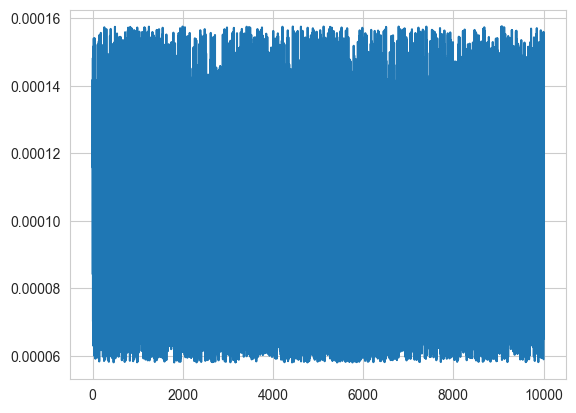

In [4]:
a = torch.rand(10000)
a_dist = m(a)

sns.set_style("whitegrid")
plt.plot(a_dist)
plt.show()

In [5]:
p = nn.Parameter(torch.rand(10000))
w1 = Variable(p, requires_grad=True)
w1

tensor([0.8044, 0.8632, 0.5470,  ..., 0.4942, 0.9625, 0.3417],
       requires_grad=True)

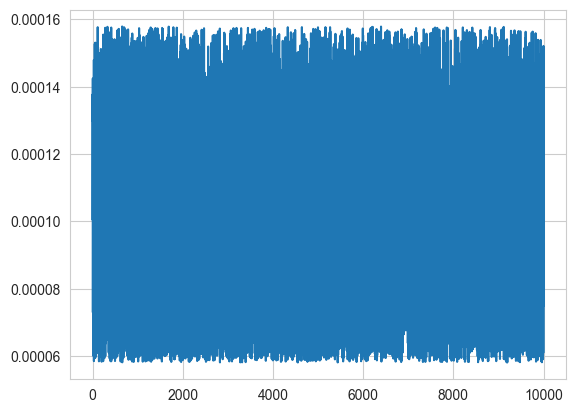

In [6]:
p_dist = m(p)
plt.plot(p_dist.detach().numpy())
plt.show()

In [7]:
learning_rate = 5e5
for t in range(150):
    
    input = F.log_softmax(w1, dim=0)
    log_target = F.log_softmax(a, dim=0)

    loss = -kl_loss(input, log_target)
    loss.backward()

    # Update weights using gradient descent; w1.data and w2.data are Tensors,
    # w1.grad and w2.grad are Variables and w1.grad.data and w2.grad.data are
    # Tensors.
    w1.data -= learning_rate * w1.grad.data

    #print(w1.data)

    # Manually zero the gradients after updating weights
    w1.grad.data.zero_()


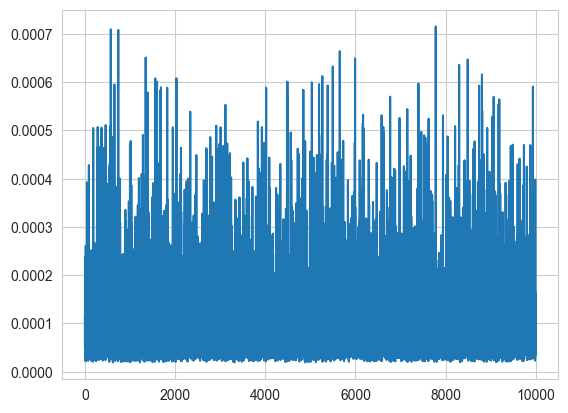

In [8]:
p_dist = m(p)
plt.plot(p_dist.detach().numpy())
plt.show()

In [53]:
import pdb

from re import L
import torch
import math
import numpy as np
import torch.nn.functional as F
from torch.nn.modules import Module
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from transformers.utils import logging

limit_a, limit_b, epsilon = -.1, 1.1, 1e-6
logger = logging.get_logger(__name__)

class L0Module(Module):
    def __init__(self,
                 config, 
                 droprate_init=0.5,
                 temperature=2./3.,
                 lagrangian_warmup=0,
                 start_sparsity=0.0,
                 target_sparsity=0.0,
                 pruning_type="structured_heads+structured_mlp+hidden+layer",
                 magical_number=0.8, # from Wang et al. 2020
                 ):
        super(L0Module, self).__init__()
        self.all_types = ["hidden_z", "intermediate_z", "mlp_z", "head_layer_z", "head_z"]
        self.pruning_type = pruning_type
        
        # model parameters
        self.vocab_size = config.vocab_size
        self.d_model = config.d_model  # hidden_size
        self.encoder_layers = config.encoder_layers
        self.encoder_attention_heads = config.encoder_attention_heads  # num_attention_heads
        self.decoder_layers = config.decoder_layers
        self.decoder_attention_heads = config.decoder_attention_heads  # num_attention_heads
        self.decoder_ffn_dim = config.decoder_ffn_dim  # intermediate_size
        self.encoder_ffn_dim = config.encoder_ffn_dim  # intermediate_size
        self.num_hidden_layers = config.encoder_layers
        self.mlp_num_per_layer = 1  # linear -> activation -> linear
        self.dim_per_encoder_head = self.d_model // self.encoder_attention_heads
        self.dim_per_decoder_head = self.d_model // self.decoder_attention_heads

        # same number of heads, head size for encoder, decoder 
        self.params_per_head_layer = self.d_model * self.d_model * 4  # + self.d_model * 4
        self.params_per_head =  self.params_per_head_layer // self.encoder_attention_heads
        
        # same intermediate size for encoder, decoder
        self.params_per_mlp_layer = self.d_model * config.encoder_ffn_dim * 2  # + self.d_model + self.d_model * 4
        self.params_per_encoder_ffn_dim = self.params_per_mlp_layer // self.encoder_ffn_dim

        # we ignore the parameters in normalization layers (it takes a very small amount)
        self.full_model_size = (self.params_per_head_layer + self.params_per_mlp_layer) * self.num_hidden_layers
        self.prunable_model_size = 0 

        self.temperature = temperature
        self.droprate_init = droprate_init if droprate_init != 0. else 0.5
        
        self.types = []
        self.z_logas = {}
        self.parameters_per_dim = {}
        self.sizes = {}
        self.shapes = {}

        self.hidden_loga = None
        self.hidden_type = None

        types = self.pruning_type.split("+")
        for type in types:
            if type != "layer":
                self.initialize_one_module(type)
        if "layer" in types:
            self.initialize_one_module("layer")

        self.magical_number = magical_number

        self.lambda_1 = torch.nn.Parameter(torch.tensor(0.0))
        self.lambda_2 = torch.nn.Parameter(torch.tensor(0.0))

        self.lagrangian_warmup = lagrangian_warmup
        self.start_sparsity = start_sparsity
        self.target_sparsity = target_sparsity

        logger.info("********** Initializing L0 Module **********") 
        for type in self.types:
            logger.info(f"***** {type} *****")
            logger.info(f"z.shape", self.z_logas[type].shape)
            logger.info(f"size", self.sizes[type])
        logger.info(f"prunable model size: {self.prunable_model_size}")

    def set_lagrangian_warmup_steps(self, lagrangian_warmup):
        self.lagrangian_warmup = lagrangian_warmup

    def initialize_one_module(self, module_name):
        if module_name == "structured_mlp":
            self.initialize_structured_mlp()
        elif module_name == "structured_heads":
            self.initialize_structured_head()
        elif module_name == "hidden":
            self.initialize_hidden()
        elif module_name == "layer":
            self.initialize_whole_mlp()
            self.initialized_layer_structured_heads()
            
    def add_one_module(self, z_loga, type, parameter_per_dim, size, shape): #! init the z_logas
        self.types.append(type)
        self.z_logas[type] = z_loga
        self.parameters_per_dim[type] = parameter_per_dim
        self.sizes[type] = size
        self.shapes[type] = shape

    def initialize_parameters(self, size, num_layer=None):
        if num_layer is not None:
            return Parameter(torch.Tensor(num_layer, size))
        else:
            return Parameter(torch.Tensor(size))

    def initialize_hidden(self):
        self.hidden_loga = self.initialize_parameters(self.d_model)
        self.add_one_module(self.hidden_loga, type="hidden", 
                            parameter_per_dim=self.d_model * 4 + self.d_model* 4 * 2,
                            size=self.d_model, shape=[self.d_model])
        self.reset_loga(self.hidden_loga, mean=10)
        logger.info(f"Initialized hidden loga! Prunable_model_size = {self.prunable_model_size}")

    def initialize_structured_head(self, add_prunable_model_size=True):
        self.head_loga = self.initialize_parameters(self.encoder_attention_heads, self.num_hidden_layers)
        self.reset_loga(self.head_loga, mean=10)
        self.add_one_module(self.head_loga, type="head", 
                            parameter_per_dim=self.params_per_head, size=self.encoder_attention_heads,
                            shape=[self.num_hidden_layers, 1, self.encoder_attention_heads, 1, 1])
        if add_prunable_model_size:
            self.prunable_model_size += self.params_per_head * self.num_hidden_layers * self.encoder_attention_heads
        logger.info(f"Initialized structured heads! Prunable_model_size = {self.prunable_model_size}")

    def initialized_layer_structured_heads(self):
        n_layer = self.num_hidden_layers
        self.headlayer_loga = self.initialize_parameters(n_layer)
        self.reset_loga(self.headlayer_loga, mean=10)
        self.add_one_module(self.headlayer_loga, type="head_layer", 
                            parameter_per_dim=self.params_per_head * self.encoder_attention_heads, size=1,
                            shape=[n_layer])
        logger.info(f"Initialized layerwise structured heads! Prunable_model_size = {self.prunable_model_size}")

    def initialize_structured_mlp(self):
        self.int_loga = self.initialize_parameters(self.encoder_ffn_dim, self.num_hidden_layers)

        self.add_one_module(self.int_loga, type="intermediate", 
                            parameter_per_dim=self.params_per_encoder_ffn_dim, size=self.encoder_ffn_dim,
                            shape=[self.num_hidden_layers, 1, 1, self.encoder_ffn_dim])
        self.prunable_model_size += self.params_per_mlp_layer * self.num_hidden_layers
        self.reset_loga(self.int_loga)
        logger.info(f"Initialized structured mlp! Prunable_model_size = {self.prunable_model_size}")


    def initialize_whole_mlp(self):
        n_layer = self.num_hidden_layers
        self.intlayer_loga = self.initialize_parameters(n_layer)
        self.add_one_module(self.intlayer_loga, type="mlp", 
                            parameter_per_dim=self.params_per_mlp_layer, size=self.mlp_num_per_layer,
                            shape=[n_layer])
        self.reset_loga(self.intlayer_loga, mean=10)
        logger.info(f"Initialized whole mlps! Prunable_model_size = {self.prunable_model_size}")


    def reset_loga(self, tensor, mean=None):
        if mean is None:
            mean = math.log(1 - self.droprate_init) - math.log(self.droprate_init)
        tensor.data.normal_(mean, 1e-2)

    def reset_qz_logas(self):
        for key in self.z_logas:
            if key in ["head_layer", "mlp", "head"]:
                self.reset_loga(self.z_logas[key], 10)
            else:
                self.reset_loga(self.z_logas[key])

    def constrain_parameters(self):
        def _constrain(tensor):
            tensor.data.clamp_(min=math.log(1e-2), max=math.log(1e2))
        for key in self.z_logas:
            _constrain(self.z_logas[key])

    def cdf_qz(self, x, loga):
        """Implements the CDF of the 'stretched' concrete distribution"""
        xn = (x - limit_a) / (limit_b - limit_a)
        logits = math.log(xn) - math.log(1 - xn)
        return torch.sigmoid(logits * self.temperature - loga).clamp(min=epsilon, max=1 - epsilon)

    def quantile_concrete(self, x, loga):
        y = torch.sigmoid((torch.log(x) - torch.log(1 - x) + loga) / self.temperature)
        return y * (limit_b - limit_a) + limit_a

    def get_num_parameters_for_one(self, loga, parameter_size):
        return torch.sum(1 - self.cdf_qz(0, loga)) * parameter_size

    def transform_scores_for_head(self):
        assert "head" in self.types

        if "head_layer" in self.types:
            all_head_score = 1 - self.cdf_qz(0, self.headlayer_loga)
        else:
            all_head_score = None
        head_score = 1 - self.cdf_qz(0, self.head_loga) # 12 * 12
       
        if all_head_score is not None:
            all_head_score = all_head_score.view(-1, 1, 1) # 12 * 1 * 1
        head_score = head_score.unsqueeze(-1)   # 12 * 12 * 1
       
        return all_head_score, head_score

    def get_num_parameters_for_mlp(self):
        intlayer_score = 1 - self.cdf_qz(0, self.intlayer_loga) # 12
        int_score = 1 - self.cdf_qz(0, self.int_loga) # 12 * 3072
        intlayer_score = intlayer_score.unsqueeze(-1)

        num_parameters = torch.sum(intlayer_score * int_score) * self.parameters_per_dim["intermediate"]
        return num_parameters

    def get_num_parameters_and_constraint_for_hidden(self): #! calculate the current parsity
        num_parameters = 0
       
        # 12 * 1 * 1
        # 12 * 12 * 1
        all_head_score, head_score = self.transform_scores_for_head()
        hidden_score = 1 - self.cdf_qz(0, self.hidden_loga) # 768

        if all_head_score is not None:
            head_score = (all_head_score * head_score).reshape(-1)
        else:
            head_score = head_score.reshape(-1)
        num_parameters += \
            torch.sum(torch.outer(hidden_score, head_score)) * self.parameters_per_dim["head"] / self.d_model

        intlayer_score = 1 - self.cdf_qz(0, self.intlayer_loga)  # 12
        int_score = 1 - self.cdf_qz(0, self.int_loga)  # 12 * 3072
        intlayer_score = intlayer_score.unsqueeze(-1)

        int_score = (intlayer_score * int_score).reshape(-1)
        num_parameters += torch.sum(torch.outer(hidden_score, int_score)) * 2
        return num_parameters


    def get_num_parameters_and_constraint(self):
        num_parameters = 0

        all_head_score, head_score = self.transform_scores_for_head()
        
        head_score = head_score * all_head_score
        num_parameters += torch.sum(head_score) * self.parameters_per_dim["head"]

        intlayer_score = 1 - self.cdf_qz(0, self.intlayer_loga)  # 12
        int_score = 1 - self.cdf_qz(0, self.int_loga)  # 12 * 3072
        intlayer_score = intlayer_score.unsqueeze(-1)

        int_score = int_score * intlayer_score
        num_parameters += torch.sum(int_score) * self.parameters_per_dim["intermediate"]
        return num_parameters


    def get_target_sparsity(self, pruned_steps):
        target_sparsity = (self.target_sparsity - self.start_sparsity) * min(1, pruned_steps / self.lagrangian_warmup) + self.start_sparsity
        return target_sparsity


    def lagrangian_regularization(self, pruned_steps):
        target_sparsity = self.target_sparsity
        if "hidden" in self.types:
            expected_size = self.get_num_parameters_and_constraint_for_hidden() #! calculate \bar s
        else:
            expected_size = self.get_num_parameters_and_constraint() #! calculate \bar s
        expected_sparsity = 1 - expected_size / self.prunable_model_size
        if self.lagrangian_warmup > 0:
            target_sparsity = self.get_target_sparsity(pruned_steps)
        lagrangian_loss = ( #! see appendix
                self.lambda_1 * (expected_sparsity - target_sparsity)
                + self.lambda_2 * (expected_sparsity - target_sparsity) ** 2 #! where is the lambda 1 and lambda 2 from
        )
        return lagrangian_loss, expected_sparsity, target_sparsity

    def get_eps(self, size):
        """Uniform random numbers for the concrete distribution"""
        eps = torch.FloatTensor(size).uniform_(epsilon, 1-epsilon)
        eps = Variable(eps)
        return eps

    # during training
    def _sample_z(self, loga):
        eps = self.get_eps(torch.FloatTensor(*loga.shape)).to(loga.device)
        z = self.quantile_concrete(eps, loga)
        z = F.hardtanh(z, min_val=0, max_val=1)
        return z

    # during inference
    def _deterministic_z(self, size, loga):
        # Following https://github.com/asappresearch/flop/blob/e80e47155de83abbe7d90190e00d30bfb85c18d5/flop/hardconcrete.py#L8 line 103
        expected_num_nonzeros = torch.sum(1 - self.cdf_qz(0, loga))
        expected_num_zeros = size - expected_num_nonzeros.item()
        try:
            num_zeros = round(expected_num_zeros)
        except:
            pdb.set_trace()
        soft_mask = torch.sigmoid(loga / self.temperature * self.magical_number)
        if num_zeros > 0:
            if soft_mask.ndim == 0:
                soft_mask = torch.tensor(0).to(loga.device)
            else:
                _, indices = torch.topk(soft_mask, k=num_zeros, largest=False)
                soft_mask[indices] = 0.
        return soft_mask

    def get_z_from_zs(self, zs):
        numpified_zs = {} 
        for type in self.all_types:
            name = type[:-2]
            z = zs.get(type, np.ones(self.shapes[name]))
            if torch.is_tensor(z): 
                new_z = z.squeeze().detach().cpu().numpy() > 0
            numpified_zs[name] = new_z
        return numpified_zs

    def calculate_model_size(self, zs):
        numpified_zs = self.get_z_from_zs(zs)
        hidden_z = numpified_zs["hidden"]
        intermediate_z = numpified_zs["intermediate"]
        mlp_z = numpified_zs["mlp"].reshape(-1, 1)
        head_z = numpified_zs["head"]
        head_layer_z = numpified_zs["head_layer"].reshape(-1, 1)

        remaining_hidden_dims = hidden_z.sum().item()
        remaining_intermediate_nums = intermediate_z.reshape(self.num_hidden_layers, self.encoder_ffn_dim).sum(-1).tolist()
        remaining_head_nums = head_z.reshape(self.num_hidden_layers, self.encoder_attention_heads).sum(-1).tolist()

        head_nums = np.outer((head_z * head_layer_z).reshape(-1), hidden_z).sum().item()
        intermediate_nums = np.outer((intermediate_z * mlp_z).reshape(-1), hidden_z).sum().item()

        remaining_model_size = head_nums * self.dim_per_encoder_head * 4 + intermediate_nums * 2
        pruned_model_size = self.prunable_model_size - remaining_model_size

        results = {}
        # Not multiplied with each other
        results["head_layers"] = head_layer_z.reshape(-1).astype(int).tolist()
        results["mlp_layers"] = mlp_z.reshape(-1).astype(int).tolist()
        results["hidden_dims"] = remaining_hidden_dims
        results["intermediate_dims"] = remaining_intermediate_nums
        results["head_nums"] = remaining_head_nums
        results["pruned_params"] = pruned_model_size
        results["remaining_params"] = remaining_model_size
        results["pruned_model_sparsity"] = pruned_model_size / self.prunable_model_size
        
        logger.info(f"remaining_head_layers: {head_layer_z}")
        logger.info(f"remaining_mlp_layers: {mlp_z}")
        logger.info(f"remaining_hidden_dims: {remaining_hidden_dims}")
        logger.info(f"remaining_intermediate_nums: {remaining_intermediate_nums}")
        logger.info(f"remaining_head_nums: {remaining_head_nums}")
        logger.info(f"pruned_model_size: {pruned_model_size}")
        logger.info(f"remaining_model_size: {remaining_model_size}")

        return results

        

    def forward(self, training=True,):
        zs = {f"{type}_z": [] for type in self.types}

        if training:
            for i, type in enumerate(self.types):
                loga = self.z_logas[type]
                z = self._sample_z(loga)
                zs[f"{type}_z"] = z.reshape(self.shapes[type])
        else:
            for i, type in enumerate(self.types):
                if type != "hidden": # hidden is not a per layer sample
                    loga_all_layers = self.z_logas[type]
                    for layer in range(len(loga_all_layers)):
                        loga = loga_all_layers[layer]
                        size = self.sizes[type]
                        z = self._deterministic_z(size, loga)
                        zs[f"{type}_z"].append(z.reshape(self.shapes[type][1:]))
                else:
                    z = self._deterministic_z(self.sizes[type], self.hidden_loga)
                    zs[f"{type}_z"] = z
            for type in zs:
                if type != "hidden_z":
                    zs[type] = torch.stack(zs[type])
        return zs 
 

In [54]:
from transformers import AutoConfig, WhisperForConditionalGeneration, BertModel
    
config = AutoConfig.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
l0_module = L0Module(config, lagrangian_warmup=200, target_sparsity=0.5)

In [56]:
l0_module.types

['head', 'intermediate', 'hidden', 'mlp', 'head_layer']

In [58]:
l0_module.z_logas.keys()

dict_keys(['head', 'intermediate', 'hidden', 'mlp', 'head_layer'])

In [60]:
l0_module.z_logas['head'].shape

torch.Size([12, 12])

In [61]:
l0_module.z_logas['intermediate'].shape

torch.Size([12, 3072])

In [63]:
l0_module.z_logas['hidden'].shape

torch.Size([768])

In [64]:
l0_module.z_logas['mlp'].shape

torch.Size([12])

In [65]:
l0_module.z_logas['head_layer'].shape

torch.Size([12])

In [ ]:
self.types = []
        self.z_logas = {}
        self.parameters_per_dim = {}
        self.sizes = {}
        self.shapes = {}

        self.hidden_loga = None
        self.hidden_type = None

In [10]:
print(model.model.encoder.layers[3].fc1.weight.shape)
print(model.model.encoder.layers[3].fc2.weight.shape)

torch.Size([3072, 768])
torch.Size([768, 3072])


In [45]:
config.decoder_attention_heads

12

In [13]:
# params_per_head_layer
config.d_model * config.d_model * 4 + config.d_model * 4

2362368

In [18]:
model.model.encoder.layers[3]

WhisperEncoderLayer(
  (self_attn): WhisperAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=False)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (activation_fn): GELUActivation()
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [25]:
print(model.model.encoder.layers[3].self_attn.k_proj.weight.shape)
print(model.model.encoder.layers[3].self_attn.v_proj.weight.shape)
print(model.model.encoder.layers[3].self_attn.q_proj.weight.shape)
print(model.model.encoder.layers[3].self_attn.out_proj.weight.shape)

torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])


In [43]:
model.model.encoder.layers[3].self_attn

WhisperAttention(
  (k_proj): Linear(in_features=768, out_features=768, bias=False)
  (v_proj): Linear(in_features=768, out_features=768, bias=True)
  (q_proj): Linear(in_features=768, out_features=768, bias=True)
  (out_proj): Linear(in_features=768, out_features=768, bias=True)
)

In [31]:
model = BertModel.from_pretrained("bert-base-uncased")

In [35]:
model.encoder.layer[2]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [39]:
model.encoder.layer[2].intermediate.dense.weight.shape

torch.Size([3072, 768])

In [40]:
model.encoder.layer[2].output.dense.weight.shape

torch.Size([768, 3072])

In [47]:
config.encoder_ffn_dim

3072

In [49]:
#self.params_per_mlp_layer
config.d_model * config.encoder_ffn_dim * 2 + config.d_model + config.d_model * 4

4722432

In [50]:
model.model.encoder.layers[3]

WhisperEncoderLayer(
  (self_attn): WhisperAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=False)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (activation_fn): GELUActivation()
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [51]:
model.model.encoder.layers[3].fc1.weight.shape

torch.Size([3072, 768])

In [1]:
from transformers import MarianMTModel
model = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de")

model.num_parameters()

74410496

In [4]:
from transformers import WhisperForConditionalGeneration, WhisperConfig

config = WhisperConfig.from_pretrained('openai/whisper-small')
model = WhisperForConditionalGeneration.from_pretrained('openai/whisper-small')

In [5]:
model.num_parameters()

241734912

In [6]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

241734912

In [7]:
model.model.encoder

WhisperEncoder(
  (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
  (embed_positions): Embedding(1500, 768)
  (layers): ModuleList(
    (0-11): 12 x WhisperEncoderLayer(
      (self_attn): WhisperAttention(
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (activation_fn): GELUActivation()
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwis

In [84]:
num_params = 0

num_params += model.model.encoder.conv1.weight.numel()
num_params += model.model.encoder.conv1.bias.numel()
num_params += model.model.encoder.conv2.weight.numel()
num_params += model.model.encoder.conv2.bias.numel()

num_params += model.model.encoder.embed_positions.weight.numel()

attn = 0
attn += model.model.encoder.layers[0].self_attn.k_proj.weight.numel()
attn += model.model.encoder.layers[0].self_attn.v_proj.weight.numel()
attn += model.model.encoder.layers[0].self_attn.v_proj.bias.numel()
attn += model.model.encoder.layers[0].self_attn.q_proj.weight.numel()
attn += model.model.encoder.layers[0].self_attn.q_proj.bias.numel()
attn += model.model.encoder.layers[0].self_attn.out_proj.weight.numel()
attn += model.model.encoder.layers[0].self_attn.out_proj.bias.numel()
attn = attn*12

layer_norm = 0
layer_norm += model.model.encoder.layers[0].self_attn_layer_norm.weight.numel()
layer_norm += model.model.encoder.layers[0].self_attn_layer_norm.bias.numel()
layer_norm = layer_norm*12

ffn = 0
ffn += model.model.encoder.layers[0].fc1.weight.numel()
ffn += model.model.encoder.layers[0].fc1.bias.numel()
ffn += model.model.encoder.layers[0].fc2.weight.numel()
ffn += model.model.encoder.layers[0].fc2.bias.numel()
ffn = ffn*12

final_layer_norm = 0
final_layer_norm += model.model.encoder.layers[i].final_layer_norm.weight.numel()
final_layer_norm += model.model.encoder.layers[i].final_layer_norm.bias.numel()
final_layer_norm = final_layer_norm*12

num_params += (attn + layer_norm + ffn + final_layer_norm)

num_params += model.model.encoder.layer_norm.weight.numel()
num_params += model.model.encoder.layer_norm.bias.numel()

In [85]:
model.model.encoder.num_parameters()

88154112

In [86]:
num_params

88154112

In [83]:
model.model.encoder.layers[0].self_attn.v_proj.bias.shape

torch.Size([768])

In [77]:
config.d_model

768

In [88]:
model.model.encoder.layers[0].fc1.weight.shape

torch.Size([3072, 768])

In [89]:
model.model.encoder.layers[0].fc1.bias.shape

torch.Size([3072])

In [90]:
model.model.encoder.layers[0].fc2.weight.shape

torch.Size([768, 3072])

In [91]:
model.model.encoder.layers[0].fc2.bias.shape

torch.Size([768])